# Вебинар 6. Двухуровневые модели рекомендаций


Код для src, utils, metrics вы можете скачать из [этого](https://github.com/geangohn/recsys-tutorial) github репозитория

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from src.metrics import precision_at_k, recall_at_k
from src.utils import prefilter_items
from src.recommenders import MainRecommender

In [775]:
data = pd.read_csv('retail_train.csv')
item_features = pd.read_csv('product.csv')
user_features = pd.read_csv('hh_demographic.csv')

# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': 'item_id'}, inplace=True)
user_features.rename(columns={'household_key': 'user_id'}, inplace=True)


# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)
val_lvl_1_size_weeks = 6
val_lvl_2_size_weeks = 3


data_for_features = data[data['week_no'] < data['week_no'].max() - val_lvl_2_size_weeks]


data_train_lvl_1 = data[data['week_no'] < data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)]
data_val_lvl_1 = data[(data['week_no'] >= data['week_no'].max() - (val_lvl_1_size_weeks + val_lvl_2_size_weeks)) &
                      (data['week_no'] < data['week_no'].max() - (val_lvl_2_size_weeks))]

data_train_lvl_2 = data_val_lvl_1.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться
data_val_lvl_2 = data[data['week_no'] >= data['week_no'].max() - val_lvl_2_size_weeks]

data_train_lvl_1.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


In [3]:
n_items_before = data_train_lvl_1['item_id'].nunique()

data_train_lvl_1 = prefilter_items(data_train_lvl_1, item_features=item_features)

n_items_after = data_train_lvl_1['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

C:\Users\Pavel\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


Decreased # items from 83685 to 4918


In [6]:
recommender = MainRecommender(data_train_lvl_1)

In [7]:
recommender.get_als_recommendation(2375, N=5)

[899624, 999999, 845208, 956609, 871756]

In [8]:
recommender.get_own_recommendation(2375, N=5)

[1068562, 1036501, 5574377, 1005935, 949836]

In [9]:
recommender.get_similar_items_recommendation(2375, N=5)

[1076056, 9527160, 819255, 1013149, 1046545]

In [10]:
recommender.get_similar_users_recommendation(2375, N=5)

[999999, 13842214, 964594, 9189814, 1139782]

### Задание 1

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_lvl_1: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?


In [73]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


#### Возникла сложность с юзерами, которых не было на обучении, но для которых нужно давать предсказания - ихо просто нет в матрице userid_to_id. Для таких пользователей просто дал топ популярных

In [74]:
result_lvl_1['similar_users'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_users_recommendation(x, N=50))

In [75]:
result_lvl_1['similar_items'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_similar_items_recommendation(x, N=50))

In [76]:
result_lvl_1['als'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_als_recommendation(x, N=50))

In [77]:
result_lvl_1['own'] = result_lvl_1['user_id'].apply(lambda x: recommender.get_own_recommendation(x, N=50))

In [78]:
result_lvl_1.head(3)

,user_id,actual,similar_users,similar_items,als,own
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[999999, 1022795, 937686, 1040812, 975649, 983...","[1076056, 824758, 9526410, 826597, 944836, 942...","[1082212, 824758, 1047619, 998558, 934399, 934...","[856942, 9297615, 1074612, 5577022, 9655212, 1..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[999999, 973861, 946977, 893018, 9707137, 1118...","[1076056, 819978, 880888, 826597, 6632986, 113...","[999999, 880150, 885023, 976199, 8014645, 9264...","[1076580, 911974, 947427, 838136, 820301, 1118..."
2,4,"[883932, 970760, 1035676, 1055863, 1097610, 67...","[999999, 1113588, 978974, 1062966, 5585510, 86...","[1076056, 835530, 1111786, 902172, 1105301, 84...","[891423, 882604, 902172, 846550, 1119454, 8839...","[891423, 910109, 6773204, 887003, 1121367, 111..."


In [82]:
models = result_lvl_1.columns[2:]
score = []
for model_ in models:
    score.append(result_lvl_1.apply(lambda x: recall_at_k(x[model_], x['actual'], k=50), axis=1).mean())    

evaluation = pd.DataFrame({'model': models, 'recall': score})
evaluation.sort_values('recall', ascending=False)

,model,recall
3,own,0.073399
2,als,0.044257
1,similar_items,0.027057
0,similar_users,0.008725


#### Лучший результат показали собственные рекоммендации (мы уже проделывали это на одном из прошлых вебинаров, действительно - пользователь больше всего похож сам на себя).

In [83]:
k = [20, 50, 100, 200, 500, 700]

In [84]:
result_lvl_1 = data_val_lvl_1.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_1.columns=['user_id', 'actual']
result_lvl_1.head(2)

for i in k:
    result_lvl_1['als ' + str(i)] = result_lvl_1['user_id'].apply(lambda x: recommender.get_als_recommendation(x, N=i))

In [85]:
models = result_lvl_1.columns[2:]
recall = []
precision = []
for model_ in models:
    recall.append(result_lvl_1.apply(lambda x: recall_at_k(x[model_], x['actual'], k=700), axis=1).mean())   
    precision.append(result_lvl_1.apply(lambda x: precision_at_k(x[model_], x['actual'], k=700), axis=1).mean())   
    

evaluation = pd.DataFrame({'model': models, 'recall': recall, 'precision': precision})
evaluation

,model,recall,precision
0,als 20,0.023598,0.067247
1,als 50,0.044257,0.054048
2,als 100,0.068084,0.043890
3,als 200,0.102788,0.034357
4,als 500,0.172579,0.023422
5,als 700,0.203296,0.019897


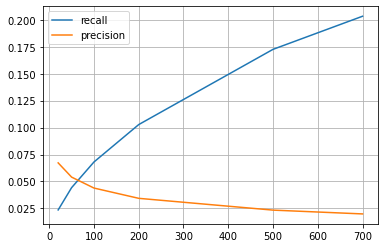

In [89]:
plt.plot(k, recall, label='recall')
plt.plot(k, precision, label='precision')
plt.grid()
plt.legend()

#### Сложно дать конкретный ответ, какое К лучше. Мы не хотим брать слишком большое К, потому что теряется сама идея двухуровневости. Мы не хотим брать слишком маленькое К, поскольку на может достаться слабая выборка по пользователю, и как её не ранжируй - предсказание будет плохое.  <br>
#### Вижу два варианта подбора: 1) ALS возвращает K лучших рекоммендаций и их score. Можно посмотреть, сколько в среднем предсказаний дается с приемлемым результатом. 2) Метод экспериментов, попробовать разное и посмотреть на итоговую метрику  

### Задание 2.

Обучите модель 2-ого уровня, при этом:
    - Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар
    - Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_lvl_2
    - Вырос ли precision@5 при использовании двухуровневой модели?

In [790]:
data_for_features.head(5)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


In [845]:
## средний чек
mean_sales_value = data_for_features.groupby(['user_id']).sum()['sales_value'] \
                      /  data_for_features.groupby(['user_id'])['basket_id'].nunique()

In [846]:
mean_sales_value = mean_sales_value.reset_index()
mean_sales_value.columns=['user_id', 'mean_sales_value']

In [859]:
## количество уникальных магазинов
shops_number = data_for_features.groupby(['user_id'])['store_id'].nunique()
shops_number =  shops_number.reset_index()
shops_number.columns=['user_id', 'shops_number']

In [862]:
## количество уникальных таваров
items_number = data_for_features.groupby(['user_id'])['item_id'].nunique()
items_number =  items_number.reset_index()
items_number.columns=['user_id', 'items_number']

In [871]:
## минимальное что-то 
#coupon_match_disc_min = 
coupon_match_disc = data_for_features.groupby(['user_id'])['coupon_match_disc'].min()
coupon_match_disc =  coupon_match_disc.reset_index()
coupon_match_disc.columns=['user_id', 'coupon_match_disc']

сначала просто выполним код без доп. фичей, чтобы посмотреть какой у нас результат. Потом попробуем улучшить

In [872]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [873]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


In [874]:
users_lvl_2 = pd.DataFrame(data_train_lvl_2['user_id'].unique())
users_lvl_2.columns = ['user_id']

# Пока только warm start
train_users = data_train_lvl_1['user_id'].unique()
users_lvl_2 = users_lvl_2[users_lvl_2['user_id'].isin(train_users)]

users_lvl_2['candidates'] = users_lvl_2['user_id'].apply(lambda x: recommender.get_als_recommendation(x, N=150))

In [875]:
df=pd.DataFrame({'user_id':users_lvl_2.user_id.values.repeat(len(users_lvl_2.candidates[0])),
                 'item_id':np.concatenate(users_lvl_2.candidates.values)})

In [876]:
targets_lvl_2 = data_train_lvl_2[['user_id', 'item_id']].copy()
targets_lvl_2['target'] = 1  # тут только покупки 

targets_lvl_2 = df.merge(targets_lvl_2, on=['user_id', 'item_id'], how='left')

targets_lvl_2['target'].fillna(0, inplace= True)

In [877]:
targets_lvl_2 = targets_lvl_2.merge(item_features, on='item_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(user_features, on='user_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(mean_sales_value, on='user_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(shops_number, on='user_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(items_number, on='user_id', how='left')
targets_lvl_2 = targets_lvl_2.merge(coupon_match_disc, on='user_id', how='left')

targets_lvl_2.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,mean_sales_value,shops_number,items_number,coupon_match_disc
0,2070,999999,0.0,NaN,NaN,NaN,NaN,NaN,NaN,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,11.816961,5,1068,-0.5
1,2070,899624,1.0,69.0,PRODUCE,Private,POTATOES,POTATOES RUSSET (BULK&BAG),10 LB,45-54,U,50-74K,Unknown,Unknown,1,None/Unknown,11.816961,5,1068,-0.5


In [886]:
X_train.columns[2:15]

Index(['manufacturer', 'department', 'brand', 'commodity_desc',
       'sub_commodity_desc', 'curr_size_of_product', 'age_desc',
       'marital_status_code', 'income_desc', 'homeowner_desc', 'hh_comp_desc',
       'household_size_desc', 'kid_category_desc'],
      dtype='object')

In [879]:
X_train = targets_lvl_2.drop('target', axis=1)
y_train = targets_lvl_2[['target']]

In [887]:
cat_feats = X_train.columns[2:15].tolist()
X_train[cat_feats] = X_train[cat_feats].astype('category')

In [888]:
from lightgbm import LGBMRanker

lgb_params = { 
    'objective':'lambdarank',
    'boosting_type': 'gbdt',
    'n_estimators': 500,
    'learning_rate': 0.1,
    'max_depth': 4,
    'categorical_column': cat_feats,
    'random_state': 27,
    'verbose': 1,
    'is_unbalance': True
}

In [889]:
X_train['num'] = np.arange(len(X_train))

In [890]:
gr = X_train[['user_id', 'num']].groupby('user_id', sort=False).max()['num'].values
gr

array([   150,    302,    455, ..., 327393, 327543, 327693])

In [891]:
grs = np.concatenate((np.array([gr[0]+1]), gr[1:] - gr[:-1]))
grs

array([151, 152, 153, ..., 150, 150, 150])

In [893]:
X_train.drop('num', axis=1, inplace=True)

In [894]:
lgb = LGBMRanker(**lgb_params, silent=False)
lgb.fit(X_train, y_train, group=grs,
        eval_set=[(X_train, y_train)], eval_group=[grs], 
        
        eval_metric=['ndcg'],
        eval_at=[5, 10 ], early_stopping_rounds=50)

C:\Users\Pavel\Anaconda3\lib\site-packages\lightgbm\basic.py:863: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[1]	training's ndcg@5: 0.326608	training's ndcg@10: 0.341327
Training until validation scores don't improve for 50 rounds
[2]	training's ndcg@5: 0.337899	training's ndcg@10: 0.347301
[3]	training's ndcg@5: 0.345204	training's ndcg@10: 0.353525
[4]	training's ndcg@5: 0.348468	training's ndcg@10: 0.355749
[5]	training's ndcg@5: 0.351795	training's ndcg@10: 0.358778
[6]	training's ndcg@5: 0.349903	training's ndcg@10: 0.359451
[7]	training's ndcg@5: 0.350619	training's ndcg@10: 0.361679
[8]	training's ndcg@5: 0.351107	training's ndcg@10: 0.361473
[9]	training's ndcg@5: 0.352829	training's ndcg@10: 0.362916
[10]	training's ndcg@5: 0.353655	training's ndcg@10: 0.362952
[11]	training's ndcg@5: 0.355797	training's ndcg@10: 0.362977
[12]	training's ndcg@5: 0.355747	training's ndcg@10: 0.363699
[13]	training's ndcg@5: 0.357233	training's ndcg@10: 0.363879
[14]	training's ndcg@5: 0.357266	training's ndcg@10: 0.364572
[15]	training's ndcg@5: 0.357136	training's ndcg@10: 0.365103
[16]	training's nd

[133]	training's ndcg@5: 0.429774	training's ndcg@10: 0.433837
[134]	training's ndcg@5: 0.430611	training's ndcg@10: 0.434166
[135]	training's ndcg@5: 0.431444	training's ndcg@10: 0.434737
[136]	training's ndcg@5: 0.431673	training's ndcg@10: 0.435166
[137]	training's ndcg@5: 0.432021	training's ndcg@10: 0.435554
[138]	training's ndcg@5: 0.43257	training's ndcg@10: 0.436009
[139]	training's ndcg@5: 0.432315	training's ndcg@10: 0.436757
[140]	training's ndcg@5: 0.433191	training's ndcg@10: 0.437294
[141]	training's ndcg@5: 0.435234	training's ndcg@10: 0.438917
[142]	training's ndcg@5: 0.435688	training's ndcg@10: 0.439263
[143]	training's ndcg@5: 0.437204	training's ndcg@10: 0.440155
[144]	training's ndcg@5: 0.437898	training's ndcg@10: 0.440903
[145]	training's ndcg@5: 0.43871	training's ndcg@10: 0.441661
[146]	training's ndcg@5: 0.439332	training's ndcg@10: 0.442074
[147]	training's ndcg@5: 0.440136	training's ndcg@10: 0.44301
[148]	training's ndcg@5: 0.44089	training's ndcg@10: 0.443

[269]	training's ndcg@5: 0.5066	training's ndcg@10: 0.500239
[270]	training's ndcg@5: 0.50715	training's ndcg@10: 0.500635
[271]	training's ndcg@5: 0.507569	training's ndcg@10: 0.501081
[272]	training's ndcg@5: 0.508599	training's ndcg@10: 0.502122
[273]	training's ndcg@5: 0.509565	training's ndcg@10: 0.502912
[274]	training's ndcg@5: 0.50992	training's ndcg@10: 0.503622
[275]	training's ndcg@5: 0.510498	training's ndcg@10: 0.504131
[276]	training's ndcg@5: 0.51109	training's ndcg@10: 0.504421
[277]	training's ndcg@5: 0.511187	training's ndcg@10: 0.504545
[278]	training's ndcg@5: 0.512034	training's ndcg@10: 0.505279
[279]	training's ndcg@5: 0.512967	training's ndcg@10: 0.50632
[280]	training's ndcg@5: 0.514286	training's ndcg@10: 0.506978
[281]	training's ndcg@5: 0.514936	training's ndcg@10: 0.507299
[282]	training's ndcg@5: 0.51505	training's ndcg@10: 0.507806
[283]	training's ndcg@5: 0.51557	training's ndcg@10: 0.508042
[284]	training's ndcg@5: 0.516312	training's ndcg@10: 0.508547


[404]	training's ndcg@5: 0.573286	training's ndcg@10: 0.562796
[405]	training's ndcg@5: 0.573572	training's ndcg@10: 0.563228
[406]	training's ndcg@5: 0.573711	training's ndcg@10: 0.563444
[407]	training's ndcg@5: 0.574175	training's ndcg@10: 0.56366
[408]	training's ndcg@5: 0.574191	training's ndcg@10: 0.563903
[409]	training's ndcg@5: 0.574655	training's ndcg@10: 0.564319
[410]	training's ndcg@5: 0.574874	training's ndcg@10: 0.564371
[411]	training's ndcg@5: 0.575322	training's ndcg@10: 0.564565
[412]	training's ndcg@5: 0.576292	training's ndcg@10: 0.565406
[413]	training's ndcg@5: 0.576309	training's ndcg@10: 0.565676
[414]	training's ndcg@5: 0.576204	training's ndcg@10: 0.566029
[415]	training's ndcg@5: 0.576381	training's ndcg@10: 0.566323
[416]	training's ndcg@5: 0.577068	training's ndcg@10: 0.566685
[417]	training's ndcg@5: 0.577569	training's ndcg@10: 0.566864
[418]	training's ndcg@5: 0.578427	training's ndcg@10: 0.56727
[419]	training's ndcg@5: 0.57874	training's ndcg@10: 0.56

LGBMRanker(categorical_column=['manufacturer', 'department', 'brand',
                               'commodity_desc', 'sub_commodity_desc',
                               'curr_size_of_product', 'age_desc',
                               'marital_status_code', 'income_desc',
                               'homeowner_desc', 'hh_comp_desc',
                               'household_size_desc', 'kid_category_desc'],
           is_unbalance=True, max_depth=4, n_estimators=500,
           objective='lambdarank', random_state=27, silent=False, verbose=1)

In [895]:
result_lvl_2 = data_val_lvl_2.groupby('user_id')['item_id'].unique().reset_index()
result_lvl_2.columns=['user_id', 'actual']
result_lvl_2.head(3)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107..."


In [896]:
users_val_lvl_2 = pd.DataFrame(data_val_lvl_2['user_id'].unique())
users_val_lvl_2.columns = ['user_id']

# Пока только warm start
train_users = data_val_lvl_2['user_id'].unique()
users_val_lvl_2 = users_val_lvl_2[users_val_lvl_2['user_id'].isin(train_users)]

users_val_lvl_2['candidates'] = users_val_lvl_2['user_id'].apply(lambda x: recommender.get_als_recommendation(x, N=150))

In [897]:
df=pd.DataFrame({'user_id':users_val_lvl_2.user_id.values.repeat(len(users_val_lvl_2.candidates[0])),
                 'item_id':np.concatenate(users_val_lvl_2.candidates.values)})

In [737]:
#targets_val_lvl_2

In [738]:
# targets_val_lvl_2 = data_val_lvl_2[['user_id', 'item_id']].copy()
# targets_val_lvl_2['target'] = 1  # тут только покупки 

In [739]:
# targets_val_lvl_2 = df.merge(targets_val_lvl_2, on=['user_id', 'item_id'], how='left')
# targets_val_lvl_2['target'].fillna(0, inplace= True)

In [898]:
targets_val_lvl_2 = df.copy()
targets_val_lvl_2 = targets_val_lvl_2.merge(item_features, on='item_id', how='left')
targets_val_lvl_2 = targets_val_lvl_2.merge(user_features, on='user_id', how='left')
targets_val_lvl_2 = targets_val_lvl_2.merge(mean_sales_value, on='user_id', how='left')
targets_val_lvl_2 = targets_val_lvl_2.merge(shops_number, on='user_id', how='left')
targets_val_lvl_2 = targets_val_lvl_2.merge(items_number, on='user_id', how='left')
targets_val_lvl_2 = targets_val_lvl_2.merge(coupon_match_disc, on='user_id', how='left')

In [899]:
X_val = targets_val_lvl_2

In [900]:
cat_feats = X_val.columns[2:15].tolist()
X_val[cat_feats] = X_val[cat_feats].astype('category')

In [901]:
predict = lgb.predict(X_val)

In [902]:
predict.shape

(306300,)

In [903]:
prediction = df.copy()
prediction['ranking'] = predict

In [904]:
prediction.sort_values(['user_id', 'ranking'], ascending=[True,False], inplace=True)

In [905]:
prediction.loc[prediction.user_id == 3]

,user_id,item_id,ranking
159037,3,899624,1.092600
159032,3,983584,0.857835
159020,3,831063,0.578340
159143,3,838186,0.542186
159013,3,965766,0.439258
...,...,...,...
159058,3,9527290,-2.852269
159079,3,883418,-3.020806
159011,3,9526410,-3.075188
159139,3,926233,-3.346760


In [906]:
result_lvl_2['lgbm'] = result_lvl_2['user_id'].apply(lambda x:prediction['item_id'].loc[prediction.user_id == x].values[:5])

In [907]:
result_lvl_2.head(3)

,user_id,actual,lgbm
0,1,"[821867, 834484, 856942, 865456, 889248, 90795...","[8293439, 901062, 1104349, 878285, 965766]"
1,3,"[835476, 851057, 872021, 878302, 879948, 90963...","[899624, 983584, 831063, 838186, 965766]"
2,6,"[920308, 926804, 946489, 1006718, 1017061, 107...","[1098844, 1098248, 976199, 1139782, 1041157]"


In [908]:
result_lvl_2.apply(lambda x: precision_at_k(x['lgbm'], x['actual'], k=5), axis=1).mean()

0.11537708129284935

In [917]:
lgb_cl = LGBMClassifier(objective='binary', max_depth=12, categorical_column=cat_feats, )
lgb_cl.fit(X_train, y_train)

C:\Users\Pavel\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\Pavel\Anaconda3\lib\site-packages\lightgbm\basic.py:863: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


LGBMClassifier(categorical_column=['manufacturer', 'department', 'brand',
                                   'commodity_desc', 'sub_commodity_desc',
                                   'curr_size_of_product', 'age_desc',
                                   'marital_status_code', 'income_desc',
                                   'homeowner_desc', 'hh_comp_desc',
                                   'household_size_desc', 'kid_category_desc'],
               max_depth=12, objective='binary')

In [918]:
val_preds = lgb_cl.predict_proba(X_val)

In [919]:
prediction_cl = df.copy()
prediction_cl['ranking'] = val_preds[:,1]

In [920]:
prediction_cl.sort_values(['user_id', 'ranking'], ascending=[True,False], inplace=True)

In [921]:
prediction_cl.head(5)

,user_id,item_id,ranking
137753,1,8293439,0.751787
137725,1,9655212,0.574228
137805,1,901062,0.523831
137760,1,1104349,0.388922
137711,1,885290,0.386793


In [922]:
result_lvl_2['lgbm_cl'] = result_lvl_2['user_id'].apply(lambda x:prediction_cl['item_id'].loc[prediction_cl.user_id == x].values[:5])

In [923]:
result_lvl_2.apply(lambda x: precision_at_k(x['lgbm_cl'], x['actual'], k=5), axis=1).mean()

0.12389813907933328

Попытался разобраться с ранкером - получил какую-то хрень. Либо так и должно быть без нормальных доп. фичей, или где-то грубая ошибка (неправильно склеены ответы, ошибка в самом модуле src и т.д.) <br>
Испрвлять буду уже в курсовом проекте, пока что план работы понятен.

### Финальный проект

Мы уже прошли всю необходимуб теорию для финального проекта. Проект осуществляется на данных из вебинара (данные считаны в начале ДЗ).
Рекомендуем вам **начать делать проект сразу после этого домашнего задания**
- Целевая метрика - precision@5. Порог для уcпешной сдачи проекта precision@5 > 0.27%
- Будет public тестовый датасет, на котором вы сможете измерять метрику
- Также будет private тестовый датасет для измерения финального качества
- НЕ обязательно, но крайне желательно использовать 2-ух уровневые рекоммендательные системы в проекте
- Вы сдаете код проекта в виде github репозитория и csv файл с рекомендациями 